This notebook follows [Working with CRSP/COMPUSTAT in R](https://deliverypdf.ssrn.com/delivery.php?ID=534125082092086101099031025121089101033003058035043086102106075087078028022075108081098099038005016125097090115097067071013073020002055000087001100124019015004121028036054039093091072029121027127115089113106010029125095098095100070071074003028070120110&EXT=pdf&INDEX=TRUE) to process CRSP dataset and calculate the market capital.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Load local CRSP data from cvs file. Given the limit of computer memory, we focus on a subset of whole dataset.
- date
- equity ticker (TICKER)
- equity price (PRC) 
- outstanding share (SHROUT)

In [2]:
crsp_data = pd.read_csv('/Users/cheng/Documents/Research Data/CRSP_1960_2019_d.csv', engine='c', usecols=['date','TICKER', 'PRC', 'SHROUT'])

Clean the data considering the following steps:
- missing price (PRC) value
- price flag (-44, -55, ...)
- date object
- exchange place 
- duplicate values
- delisted company

In [3]:
def get_clean_data_crsp(data:pd.DataFrame) -> pd.DataFrame:
    '''Clean crsp dataset
    Clean crsp dataset in following steps:
        1. missing price (PRC) value
        2. price flag (-44, -55, ...)
        3. date object
        # TO DO
        4. exchange place
        5. duplicate values
        6. delisted company

    Args:
        data: given crsp dataset from csv.
              MUST containing date and PRC (price).
    
    Returns:
        clean crsp dataset
    '''
    data = data.dropna(subset=['PRC'])
    PRICE_FLAG = [-44, -55, -66, -77, -88, -99]
    data = data[data.PRC.isin(PRICE_FLAG) == False]
    data['date'] = [datetime.datetime.strptime(str(x), '%Y%m%d') for x in data.date]

    return data

In [4]:
crsp_data = get_clean_data_crsp(crsp_data)

Calculate the market capital of each equity
$$
MKTCAP_{i,t} = PRC_{i,t} \times SHROUT_{i,t}
$$

In [5]:
crsp_data['MKTCAP'] = crsp_data.PRC * crsp_data.SHROUT

Calculate the market capital time series

$$
MKTCAP_t = \sum_{i \in A} MKTCAP_{i,t}
$$

In [6]:
MKTCAP_ts = crsp_data[['MKTCAP','date']].groupby(['date']).sum()

Calculate the capital weight
$$
\begin{align}
W_{i,t} &= \frac{MKTCAP_{i,t}}{MKTCAP_t}\\
 &=\frac{PRC_{i,t} \times SHROUT_{i,t}}{\sum_{i \in A} MKTCAP_{i,t}}
\end{align}
$$

In [25]:
ief = crsp_data.query("TICKER == 'IEF'")
ief = ief.set_index('date')
mktcap_weight_ief = ief['MKTCAP'] / MKTCAP_ts['MKTCAP']

In [26]:
ivv = crsp_data.query("TICKER == 'IVV'")
ivv = ivv.set_index('date')
mktcap_weight_ivv = ivv['MKTCAP'] / MKTCAP_ts['MKTCAP']

Calculate the ratio between two equities' maket capital and visualize the time series.
$$
R = \frac{MKTCAP_{IEF}}{MKTCAP_{IVV}}
$$

In [64]:
ratio = ief['MKTCAP'] / ivv['MKTCAP'] 

Visualization

In the following picture, we reports the market capital weight time series. 
(a) reports the market weight of SPY, (b) reports the market weight of IEF and (c) reports the ratio between SPY and IEF.

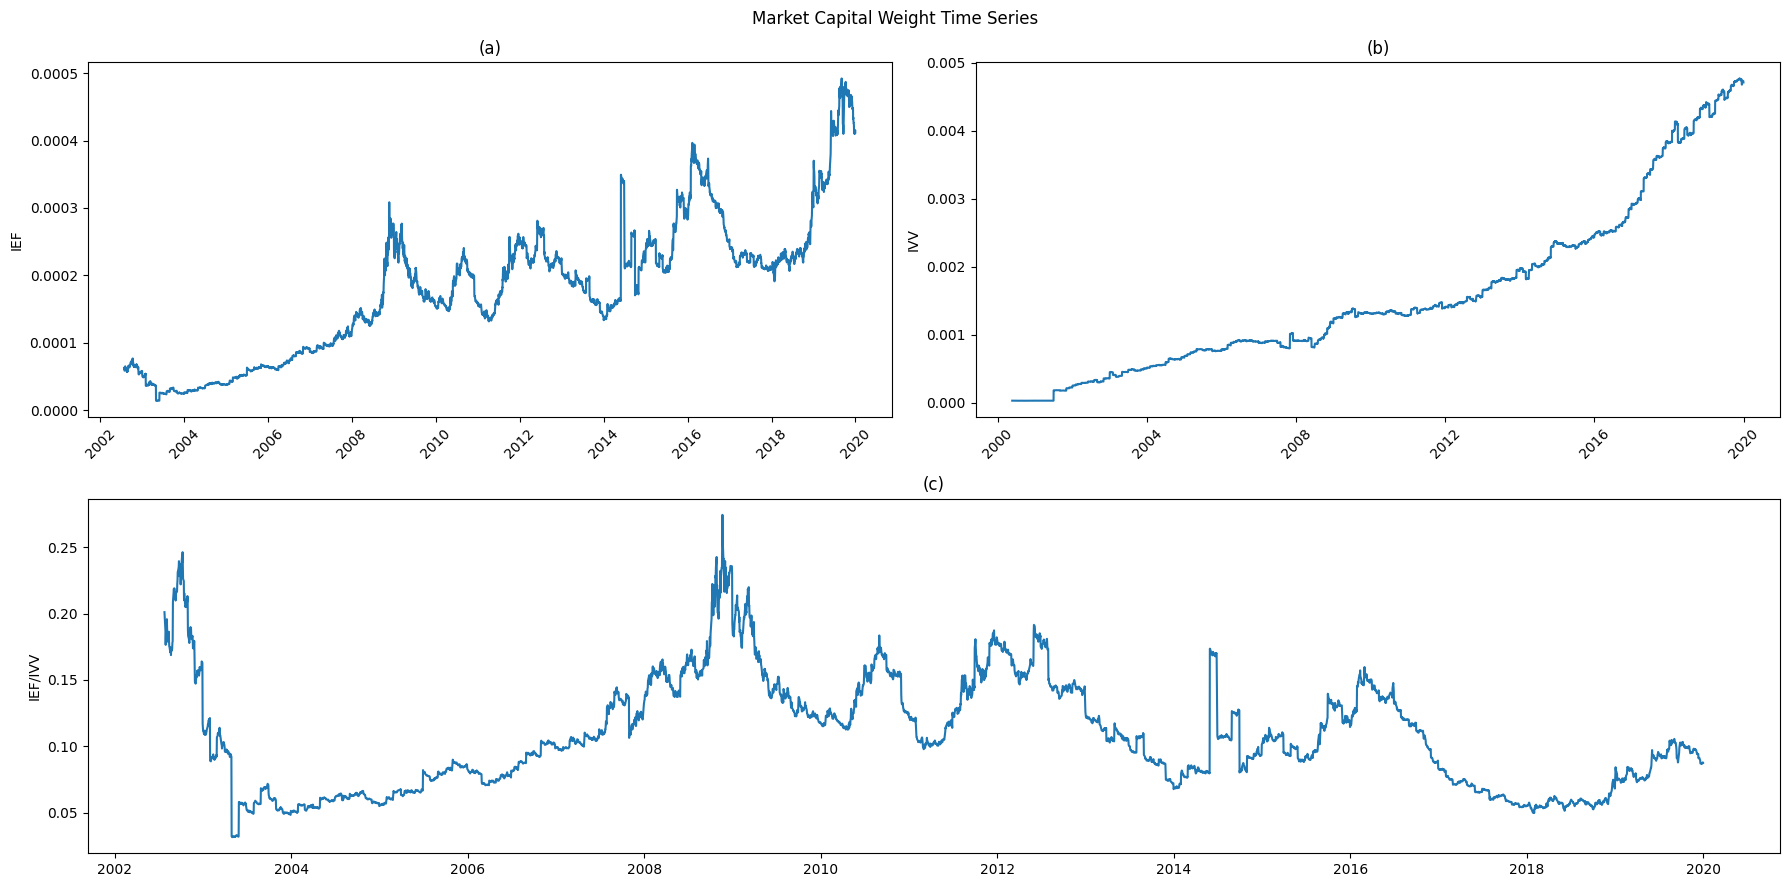

In [66]:
fig = plt.figure(figsize=(18,9))

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)

fig.suptitle('Market Capital Weight Time Series')
ax1.plot(mktcap_weight_ief)
ax1.set_ylabel('IEF')
ax1.tick_params(axis='x', rotation=45)
ax1.title.set_text('(a)')
ax2.plot(mktcap_weight_ivv)
ax2.set_ylabel('IVV')
ax2.tick_params(axis='x', rotation=45)
ax2.title.set_text('(b)')
ax3.plot(ratio)
ax3.set_ylabel('IEF/IVV')
ax3.title.set_text('(c)')
fig.tight_layout()


Assuming that the investment universe has two asset, i.e. IEF and IVV, we calculate the capital weight for each ETF.

In [54]:
# inner join IEF with IVV market capital
mktcap_df = pd.merge(ief['MKTCAP'],  
                     ivv['MKTCAP'], 
                     left_index=True, 
                     right_index=True, 
                     suffixes=('_IEF', '_IVV'))
mktcap_sum = mktcap_df.sum(axis=1)


In [60]:
mktcap_weight_ts = mktcap_df.div(mktcap_sum.values, axis=0)

In [74]:
path ='../../data/mktcap_w_ms.csv'
mktcap_weight_ts_ms = pd.read_csv(path, engine='c', index_col=0, parse_dates=True)

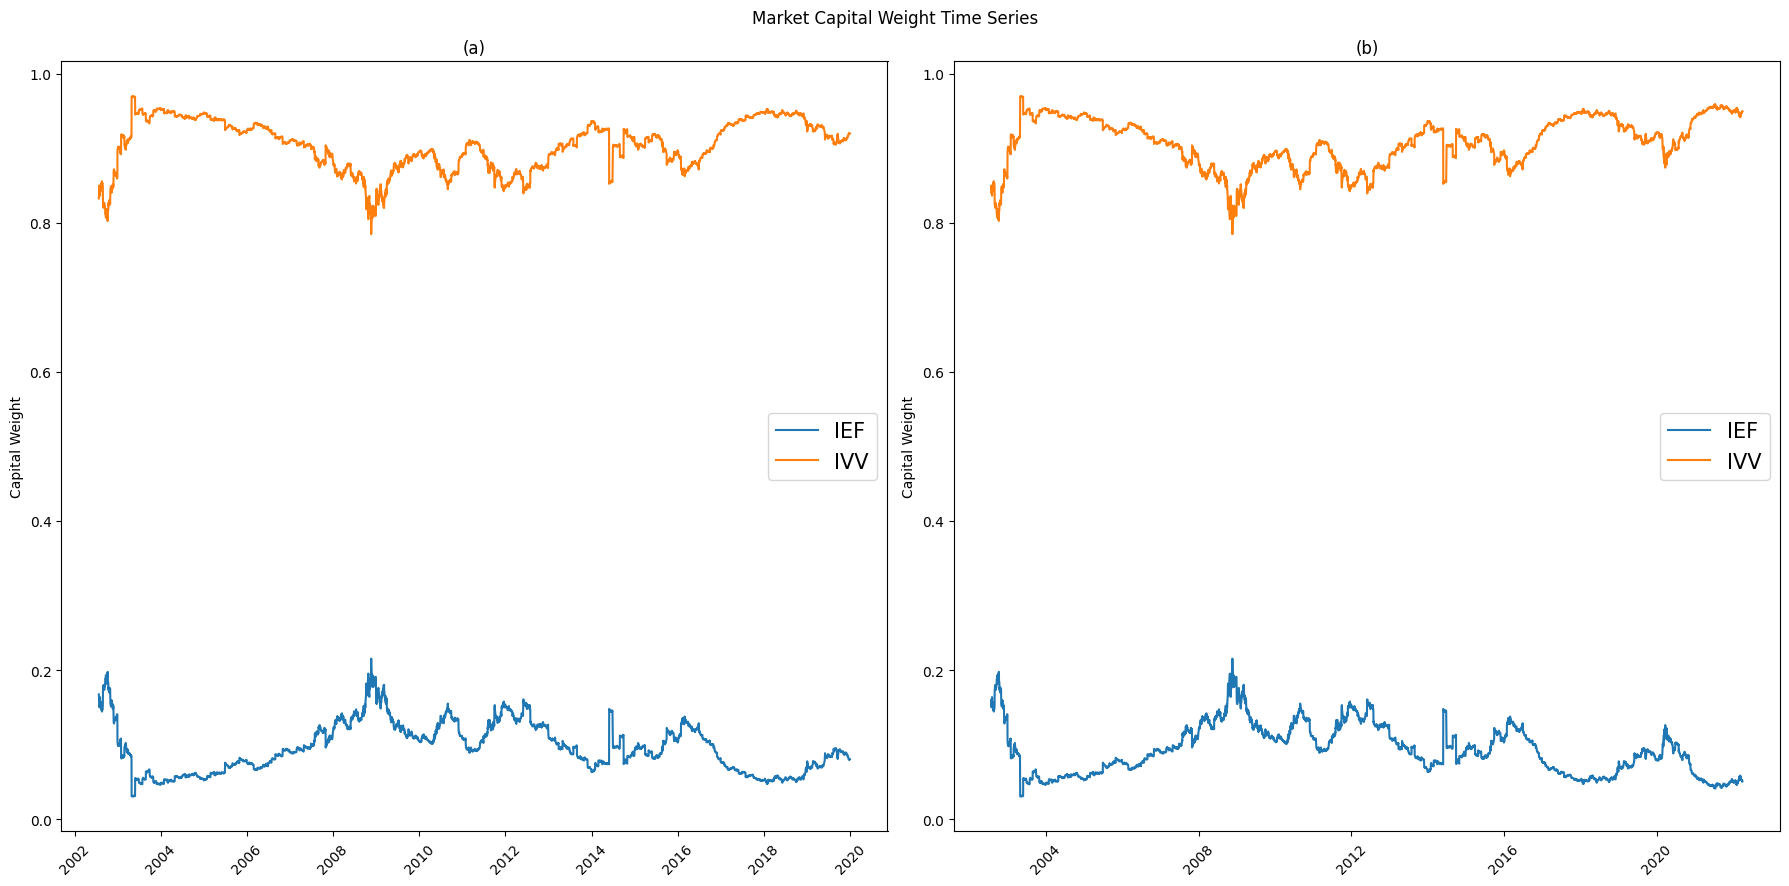

In [89]:
fig = plt.figure(figsize=(18,9))

ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
# ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)

fig.suptitle('Market Capital Weight Time Series')
ax1.plot(mktcap_weight_ts['MKTCAP_IEF'], label = 'IEF')
ax1.plot(mktcap_weight_ts['MKTCAP_IVV'], label = 'IVV')
ax1.set_ylabel('Capital Weight')
ax1.tick_params(axis='x', rotation=45)
ax1.title.set_text('(a)')
ax1.legend(loc = 'center right', prop={'size': 15})

ax2.plot(mktcap_weight_ts_ms['IEF'], label = 'IEF')
ax2.plot(mktcap_weight_ts_ms['IVV'], label = 'IVV')
ax2.set_ylabel('Capital Weight')
ax2.tick_params(axis='x', rotation=45)
ax2.title.set_text('(b)')
ax2.legend(loc = 'center right', prop={'size': 15})

fig.tight_layout()

In [91]:
mktcap_weight_ts.to_csv('../../data/mktcap_w_ief_ivv.csv')